In [1]:
import json
import pandas as pd
import os
import shutil
import datetime

DATA_DIR = "../data"
DATA_FILE = os.path.join(DATA_DIR, "data.json")
DUMP_FILE = os.path.join(DATA_DIR, "dump.pkl")

store_columns = (
    "id",  # 음식점 고유번호
    "store_name",  # 음식점 이름
    "branch",  # 음식점 지점 여부
    "area",  # 음식점 위치
    "tel",  # 음식점 번호
    "address",  # 음식점 주소
    "latitude",  # 음식점 위도
    "longitude",  # 음식점 경도
    "category",  # 음식점 카테고리
)

bhour_columns = (
    "store",  # 음식점 고유번호
    "type",  # 영업시간 종류 1- 영업시간, 2- 쉬는시간, 3- 휴무일
    "week_type",  # 주단위 종류 1-매주, 2-첫째주, 3-둘째주,4-셋째주,5-넷째주,6-공휴일
    "mon",  # 월 포함유무
    "tue",  # 화 포함유무
    "wed",  # 수 포함유무
    "thu",  # 목 포함유무
    "fri",  # 금 포함유무
    "sat",  # 토 포함유무
    "sun",  # 일 포함유무
    "start_time",  # 시작시간
    "end_time",  # 종료시간
)

review_columns = (
    "id",  # 리뷰 고유번호
    "store",  # 음식점 고유번호
    "user",  # 유저 고유번호
    "score",  # 평점
    "content",  # 리뷰 내용
    "reg_time",  # 리뷰 등록 시간
)

menu_columns = (
    "id",   # 메뉴 고유번호
    "store",  # 음식점 고유번호
    "menu_name",  # 메뉴 이름
    "price",  # 메뉴 가격
)

user_columns = (
    "id",  # 유저 고유번호
    "gender",  # 유저 성별
    "age",  # 유저 나이
)

In [3]:
def import_data(data_path=DATA_FILE):
    """
    Req. 1-1-1 음식점 데이터 파일을 읽어서 Pandas DataFrame 형태로 저장합니다
    """

    try:
        with open(data_path, encoding="utf-8") as f:
            data = json.loads(f.read())
    except FileNotFoundError as e:
        print(f"`{data_path}` 가 존재하지 않습니다.")
        exit(1)

    stores = []  # 음식점 테이블
    reviews = []  # 리뷰 테이블
    menus = []  # 메뉴 테이블
    users = []  # 유저 테이블
    bhours = []  # 영업시간 테이블
    dt = datetime.datetime.now().year

    for d in data:

        categories = [c["category"] for c in d["category_list"]]
        stores.append(
            [
                d["id"],
                d["name"],
                d["branch"],
                d["area"],
                d["tel"],
                d["address"],
                d["latitude"],
                d["longitude"],
                "|".join(categories),
            ]
        )
        if(d["review_cnt"] > 0):
            for review in d["review_list"]:
                r = review["review_info"]
                u = review["writer_info"]

                reviews.append(
                    [r["id"], d["id"], u["id"], r["score"],
                        r["content"], r["reg_time"]]
                )
                users.append(
                    [u["id"], u["gender"], dt - int(u["born_year"])+1]
                )

        index = 0
        for m in d["menu_list"]:
            index += 1
            menus.append(
                [index, d["id"], m["menu"], m["price"]]
            )

        for b in d["bhour_list"]:
            bhours.append(
                [d["id"], b["type"], b["week_type"], b["mon"], b["tue"], b["wed"],
                    b["thu"], b["fri"], b["sat"], b["sun"], b["start_time"], b["end_time"]]
            )

    store_frame = pd.DataFrame(data=stores, columns=store_columns)
    review_frame = pd.DataFrame(data=reviews, columns=review_columns)
    menu_frame = pd.DataFrame(data=menus, columns=menu_columns)
    user_frame = pd.DataFrame(data=users, columns=user_columns)
    bhour_frame = pd.DataFrame(data=bhours, columns=bhour_columns)

    return {"stores": store_frame, "reviews": review_frame, "menus": menu_frame, "users": user_frame, "bhours": bhour_frame}


def dump_dataframes(dataframes):
    pd.to_pickle(dataframes, DUMP_FILE)


def load_dataframes():
    return pd.read_pickle(DUMP_FILE)


def main():

    print("[*] Parsing data...")
    data = import_data()
    print("[+] Done")

    print("[*] Dumping data...")
    dump_dataframes(data)
    print("[+] Done\n")

    data = load_dataframes()

    term_w = shutil.get_terminal_size()[0] - 1
    separater = "-" * term_w

    print("[음식점]")
    print(f"{separater}\n")
    print(data["stores"].head())
    print(f"\n{separater}\n\n")

    print("[리뷰]")
    print(f"{separater}\n")
    print(data["reviews"].head())
    print(f"\n{separater}\n\n")

    print("[메뉴]")
    print(f"{separater}\n")
    print(data["menus"].head())
    print(f"\n{separater}\n\n")

    print("[유저]")
    print(f"{separater}\n")
    print(data["users"].head())
    print(f"\n{separater}\n\n")

    print("[영업시간]")
    print(f"{separater}\n")
    print(data["bhours"].head())
    print(f"\n{separater}\n\n")
    
# main()

In [4]:
data = load_dataframes()

In [5]:
def sort_stores_by_score(dataframes, n=20, min_reviews=30):
    """
    Req. 1-2-1 각 음식점의 평균 평점을 계산하여 높은 평점의 음식점 순으로 `n`개의 음식점을 정렬하여 리턴합니다
    Req. 1-2-2 리뷰 개수가 `min_reviews` 미만인 음식점은 제외합니다.
    """
    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    scores_group = stores_reviews.groupby(["store", "store_name"]).filter(lambda x : len(x) > min_reviews)
    scores = scores_group.groupby(["store", "store_name"]).mean()['score']
    return scores.reset_index().sort_values(by='score', ascending=False).head(n=n)


def get_most_reviewed_stores(dataframes, n=20):
    """
    Req. 1-2-3 가장 많은 리뷰를 받은 `n`개의 음식점을 정렬하여 리턴합니다
    """
    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    reviews_group = stores_reviews.groupby(["store", "store_name"]).count()['score']
    
    return reviews_group.reset_index().sort_values(by='score', ascending=False).head(n=n)


def get_most_active_users(dataframes, n=20):
    user_reviews = dataframes["reviews"].groupby('user').count()['id']
    return user_reviews.reset_index().sort_values(by='id', ascending=False).head(n=n)

In [48]:
stores_most_scored = sort_stores_by_score(data)

stores_most_scored

,store,store_name,score
5,90781,더아리엘,4.818182
3,70803,농민백암순대,4.612903
4,76200,다운타우너,4.609756
57,346836,정돈,4.430769
15,157481,미분당,4.367347
28,229027,소이연남,4.301887
50,321390,을밀대,4.285714
23,204267,사모님돈가스,4.250000
1,26012,고기리 막국수,4.244898
60,359300,중앙해장,4.212121


In [49]:
most_reviewed_stores = get_most_reviewed_stores(data)
most_reviewed_stores

,store,store_name,score
17654,145030,명동교자,101
39395,309336,우진해장국,70
44039,346836,정돈,65
23137,187601,봉포머구리집,64
39042,305906,우래옥,63
17987,147432,명진전복,61
12463,106124,동화가든,59
40744,319442,육회자매집,58
41009,321485,을지면옥,55
29989,239920,쉑쉑버거,55


In [51]:
most_active_users = get_most_active_users(data)
most_active_users

,user,id
13158,469245,461
8101,243883,389
10471,328775,380
12001,391794,362
2760,74999,352
6352,179719,317
16249,724982,285
3545,103304,282
16282,728009,271
11946,390564,268


In [103]:
import itertools
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import folium
from folium.plugins import MarkerCluster

def set_config():
    # 폰트, 그래프 색상 설정
    font_list = fm.findSystemFonts(fontpaths=None, fontext="ttf")
    if any(["notosanscjk" in font.lower() for font in font_list]):
        plt.rcParams["font.family"] = "Noto Sans CJK JP"
    else:
        if not any(["malgun" in font.lower() for font in font_list]):
            raise Exception(
                "Font missing, please install Noto Sans CJK or Malgun Gothic. If you're using ubuntu, try `sudo apt install fonts-noto-cjk`"
            )

        plt.rcParams["font.family"] = "Malgun Gothic"

    sns.set_palette(sns.color_palette("Spectral"))
    plt.rc("xtick", labelsize=6)


def show_store_categories_graph(dataframes, n=100):
    """
    Tutorial: 전체 음식점의 상위 `n`개 카테고리 분포를 그래프로 나타냅니다.
    """

    stores = dataframes["stores"]

    # 모든 카테고리를 1차원 리스트에 저장합니다
    categories = stores.category.apply(lambda c: c.split("|"))
    categories = itertools.chain.from_iterable(categories)

    # 카테고리가 없는 경우 / 상위 카테고리를 추출합니다
    categories = filter(lambda c: c != "", categories)
    categories_count = Counter(list(categories))
    best_categories = categories_count.most_common(n=n)
    df = pd.DataFrame(best_categories, columns=["category", "count"]).sort_values(
        by=["count"], ascending=False
    )

    # 그래프로 나타냅니다
    chart = sns.barplot(x="category", y="count", data=df)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("음식점 카테고리 분포")
    plt.show()


def show_store_review_distribution_graph(dataframes, n=100):
    """
    Req. 1-3-1 전체 음식점의 리뷰 개수 분포를 그래프로 나타냅니다. 
    """
    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    scores_group = stores_reviews.groupby(["store", "store_name"]).count()['score']
    scores_group = scores_group.reset_index().sort_values(by='score', ascending=False).head(n=n)
    
    chart = sns.barplot(x="store_name", y="score",data=scores_group)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("음식점 리뷰 개수 분포")
    plt.show()


def show_store_average_ratings_graph(dataframes, n=100):
    """
    Req. 1-3-2 각 음식점의 평균 평점을 그래프로 나타냅니다.
    """
    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    scores_group = stores_reviews.groupby(["store", "store_name"]).filter(lambda x : len(x) > 10)
    scores = scores_group.groupby(["store", "store_name"]).mean()['score']
    scores = scores.reset_index().sort_values(by='score', ascending=False).head(n=n)
    chart = sns.barplot(x="store_name", y="score",data=scores)
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("음식점 평균 평점 ")
    plt.show()


def show_user_review_distribution_graph(dataframes,n =100):
    """
    Req. 1-3-3 전체 유저의 리뷰 개수 분포를 그래프로 나타냅니다.
    """
    user_reviews = dataframes["reviews"].groupby('user').count()['id']
    user_reviews = user_reviews.reset_index().sort_values(by='id', ascending=False).head(n=n)
    chart = sns.distplot(user_reviews['id'])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
    plt.title("리뷰 개수 분포 ")
    plt.show()


def show_user_age_gender_distribution_graph(dataframes):
    """
    Req. 1-3-4 전체 유저의 성별/나이대 분포를 그래프로 나타냅니다.
    """
    plt.figure(figsize=(12,5))
    users = dataframes["users"]
    plt.subplot(1,2,1)
    sns.countplot(users['gender'])
    plt.title("성별 분포 ")
    plt.subplot(1,2,2)
    sns.distplot(users.loc[(users['age']<100) & (users['age']>0)]['age'], kde=False)
    plt.title("나이 분포 ")
    plt.show()


def show_stores_distribution_graph(dataframes):
    """
    Req. 1-3-5 각 음식점의 위치 분포를 지도에 나타냅니다.
    """
    stores = dataframes["stores"].dropna(axis=0,subset=["address"])
    stores = stores[stores['address'].str.contains('서울')]
    
    stores_reviews = pd.merge(
        stores, dataframes["reviews"], left_on="id", right_on="store"
    )
    scores_group = stores_reviews.groupby(["store", "store_name"]).filter(lambda x : len(x) > 10)
    scores = scores_group.groupby(["store", "store_name"]).mean()['score']
    scores = scores.reset_index().sort_values(by='score', ascending=False)
    
    scores_all = pd.merge(
        scores.drop('store_name',axis=1), stores, left_on='store',right_on='id'
    )
    
    
    map = folium.Map(location=[37.574187, 126.976882], zoom_start=15)
    
    marker_cluster = MarkerCluster().add_to(map)
    
    for idx,item in scores_all.iterrows():
        
        folium.Marker([float(item['latitude']), float(item['longitude'])], popup = item['store_name'],
                             tooltip= round(item['score'],2)).add_to(marker_cluster)
    
    return map

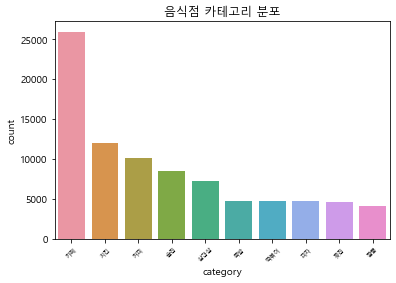

In [5]:
set_config()
show_store_categories_graph(data,10)

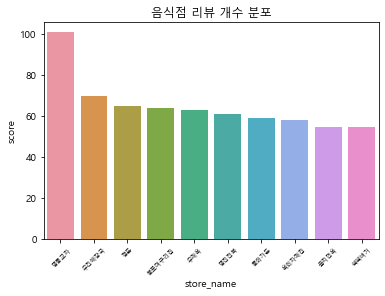

In [13]:
show_store_review_distribution_graph(data,10)

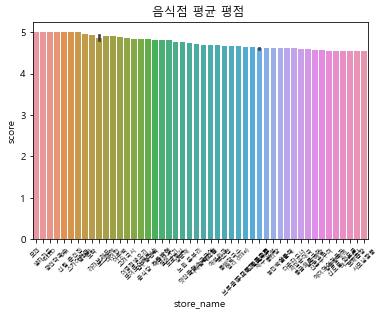

In [23]:
show_store_average_ratings_graph(data,50)

<ipython-input-47-3f48f9f5bc7a>:90: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45)


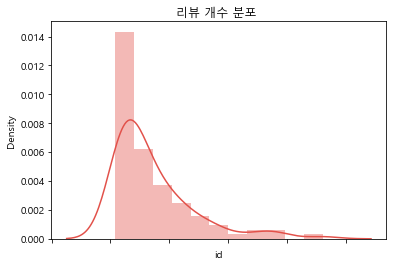

In [48]:
show_user_review_distribution_graph(data)

C:\Users\multicampus\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\multicampus\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


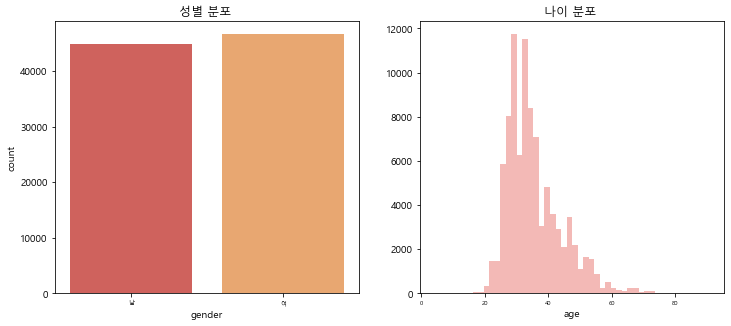

In [49]:
show_user_age_gender_distribution_graph(data)

In [104]:
show_stores_distribution_graph(data)

In [158]:
from scipy.sparse import csr_matrix

def user_store_matrix(dataframes, n=20, min_reviews=30):
    """
    Req. 1-4-1 유저-store- matrix 생성
    """
    
    stores_reviews = pd.merge(
        dataframes["stores"], dataframes["reviews"], left_on="id", right_on="store"
    )
    scores_group = stores_reviews.groupby(["store", "store_name"]).filter(lambda x : len(x) > min_reviews)
    scores_group = scores_group.groupby(
        ["store", "store_name"])
    scores = scores_group[['store', 'store_name', 'score', 'user']].head(
        n=n).set_index(['store', 'store_name'])
    user_store_score = scores.pivot_table(
        index='store_name', columns='user', values='score')
    user_store_score.fillna(0, inplace=True)
    return csr_matrix(user_store_score), user_store_score.index, user_store_score.columns

def user_category_matrix(dataframes, n=100):
    
    stores = dataframes["stores"]
    
    stores_reviews = pd.merge(
        stores, dataframes["reviews"], left_on="id", right_on="store"
    )
    stores_reviews = stores_reviews.groupby(["store", "store_name"]).filter(lambda x : len(x) > 30)
    cate_score = pd.DataFrame(columns=['user','category','score'])
    for idx,item in stores_reviews.iterrows():
        categories = item.category.split("|")
        for cate in categories:
            cate_score = cate_score.append(pd.Series([item.user,cate ,item.score],index = cate_score.columns),ignore_index=True)
    
    cate_score.score = cate_score.score.astype('int')
    scores_group = cate_score.groupby("category")
    scores = scores_group[['category', 'score', 'user']].head(n=n).set_index("category")
    user_cate_score = scores.pivot_table(
        index='category', columns='user', values='score')
    user_cate_score.fillna(0, inplace=True)


    return csr_matrix(user_cate_score), user_cate_score.index, user_cate_score.columns

In [161]:
user_store_score = user_store_matrix(data)
k = csr_matrix(user_store_score[0])
k = pd.DataFrame.sparse.from_spmatrix(k, index = user_store_score[1],columns=user_store_score[2])
k.head()

user,658,1102,2379,3996,5282,5536,5995,6838,7226,7265,...,934593,935109,936494,937496,939724,940619,942567,946187,947622,947671
store_name,,,,,,,,,,,,,,,,,,,,,
가시아방,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
고기리 막국수,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
교리김밥,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
농민백암순대,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
다운타우너,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [160]:
user_cate_score = user_category_matrix(data)
k = csr_matrix(user_cate_score[0])
k = pd.DataFrame.sparse.from_spmatrix(k)
k.head()

KeyError: 0